Linear Regression - MSE: 4652276.2090, RMSE: 2156.9136, MAE: 1495.0709, R²: 0.6240
Random Forest - MSE: 1661575.1528, RMSE: 1289.0210, MAE: 603.8611, R²: 0.8657
Gradient Boosting - MSE: 4889786.2950, RMSE: 2211.2861, MAE: 971.9769, R²: 0.6048
Support Vector Machine - MSE: 12561755.7903, RMSE: 3544.2567, MAE: 2275.3805, R²: -0.0152
XGBoost - MSE: 2997156.3438, RMSE: 1731.2297, MAE: 1096.7820, R²: 0.7578
Neural Network - MSE: 8211680.7004, RMSE: 2865.6030, MAE: 2278.9060, R²: 0.3364
Stacking Regressor - MSE: 14786641.3164, RMSE: 3845.3402, MAE: 1768.8364, R²: -0.1950
                                           Feature  Importance
17              Social Score Profit (in million $)    0.167071
31           Profit (in million $) Total ESG Score    0.137658
29                         Profit (in million $)^2    0.133890
22          Governance Score Profit (in million $)    0.132746
11       Environmental Score Profit (in million $)    0.104062
4                            Profit (in million $)

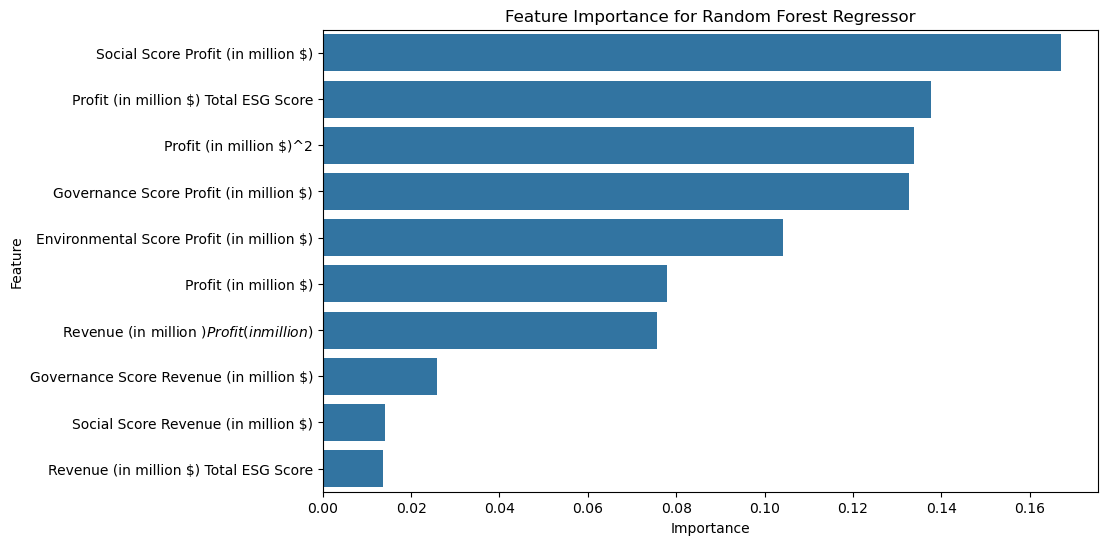

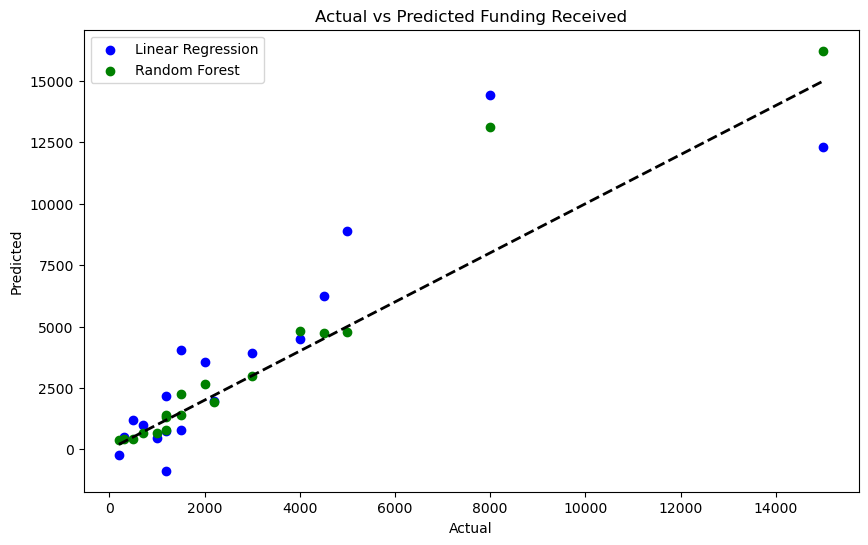

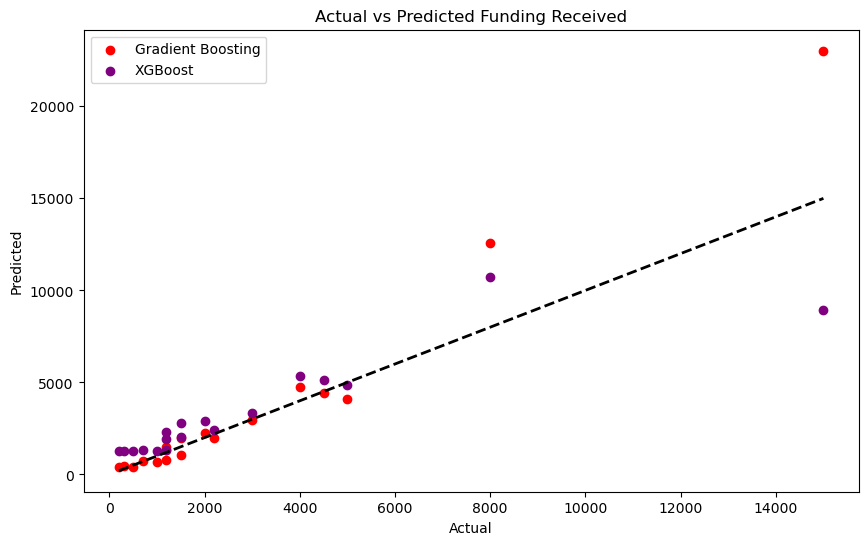

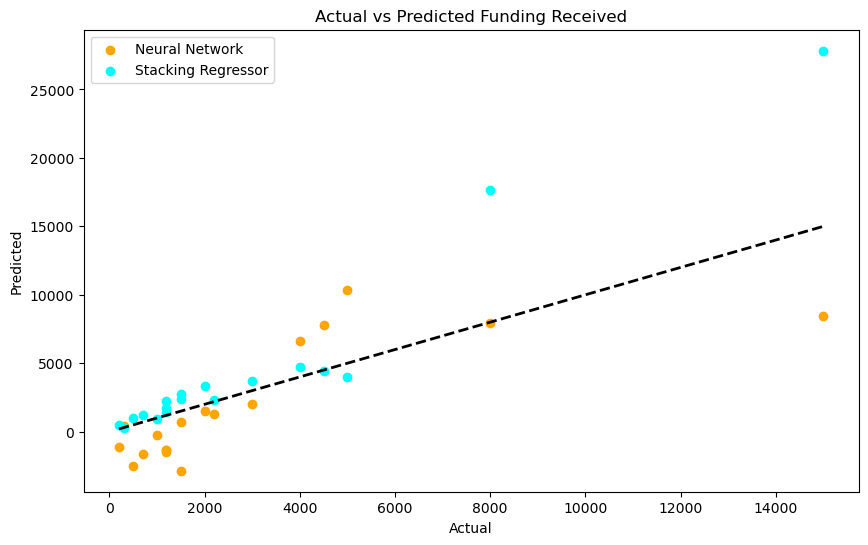

Linear Regression - MSE: 4652276.2090, RMSE: 2156.9136, MAE: 1495.0709, R²: 0.6240
Random Forest - MSE: 1661575.1528, RMSE: 1289.0210, MAE: 603.8611, R²: 0.8657
Gradient Boosting - MSE: 4889786.2950, RMSE: 2211.2861, MAE: 971.9769, R²: 0.6048
Support Vector Machine - MSE: 12561755.7903, RMSE: 3544.2567, MAE: 2275.3805, R²: -0.0152
XGBoost - MSE: 2997156.3438, RMSE: 1731.2297, MAE: 1096.7820, R²: 0.7578
Neural Network - MSE: 8211680.7004, RMSE: 2865.6030, MAE: 2278.9060, R²: 0.3364
Stacking Regressor - MSE: 14786641.3164, RMSE: 3845.3402, MAE: 1768.8364, R²: -0.1950


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# DATA SOURCE / CONFIDENTIALITY NOTE
# The dataset used in this analysis contains confidential ESG, financial, and funding information.
# It is NOT included in this public repository for data privacy reasons.
#
# To reproduce this notebook:
# 1. Prepare your own dataset with the same schema
#    (e.g. Environmental Score, Social Score, Governance Score,
#     Revenue (in million $), Profit (in million $),
#     Funding Received (in million $), etc.).
# 2. Save it locally (not committed to GitHub), e.g. data/Cleaned_ESG_Data2.csv
# 3. Update the path below to point to your local file.
#
# The code below expects the file at: data/Cleaned_ESG_Data2.csv

cleaned_data_path = "data/Cleaned_ESG_Data2.csv"  # relative path to your private/local copy
df = pd.read_csv(cleaned_data_path)


 
# Load the new cleaned ESG data CSV file (local / private, not in repo)
cleaned_data_path = "path/to/your/local/Cleaned_ESG_Data2.csv"  # <-- update this on your own machine
df = pd.read_csv(cleaned_data_path)


# Feature engineering
df['Revenue to Profit Ratio'] = df['Revenue (in million $)'] / df['Profit (in million $)']
df['Total ESG Score'] = df['Environmental Score'] + df['Social Score'] + df['Governance Score']
df.fillna(0, inplace=True)  # Replace any NaNs resulting from division by zero

# Creating polynomial features and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['Environmental Score', 'Social Score', 'Governance Score', 'Revenue (in million $)', 'Profit (in million $)', 'Revenue to Profit Ratio', 'Total ESG Score']])
poly_feature_names = poly.get_feature_names_out(['Environmental Score', 'Social Score', 'Governance Score', 'Revenue (in million $)', 'Profit (in million $)', 'Revenue to Profit Ratio', 'Total ESG Score'])

# Create a new DataFrame with the polynomial features
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)

# Feature selection
X = df_poly
y = df['Funding Received (in million $)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Machine': SVR(),
    'XGBoost': XGBRegressor(random_state=42),
    'Neural Network': MLPRegressor(random_state=42, max_iter=1000)
}

# Stratified K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameters for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

param_grid_nn = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, mae, r2

# Evaluate all models with GridSearchCV
results = {}
best_models = {}
for name, model in models.items():
    if name == 'Random Forest':
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_rf, cv=kf, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        results[name] = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
    elif name == 'Gradient Boosting':
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_gb, cv=kf, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        results[name] = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
    elif name == 'XGBoost':
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_xgb, cv=kf, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        results[name] = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
    elif name == 'Neural Network':
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid_nn, cv=kf, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        results[name] = evaluate_model(best_model, X_train_scaled, y_train, X_test_scaled, y_test)
    else:
        best_models[name] = model
        results[name] = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)

# Display results
for name, (mse, rmse, mae, r2) in results.items():
    print(f'{name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

# Stacking Regressor for ensemble method
stacking_model = StackingRegressor(
    estimators=[('rf', best_models['Random Forest']),
                ('gb', best_models['Gradient Boosting']),
                ('svm', models['Support Vector Machine']),
                ('xgb', best_models['XGBoost']),
                ('nn', best_models['Neural Network'])],
    final_estimator=LinearRegression()
)
stacking_results = evaluate_model(stacking_model, X_train_scaled, y_train, X_test_scaled, y_test)
print(f'Stacking Regressor - MSE: {stacking_results[0]:.4f}, RMSE: {stacking_results[1]:.4f}, MAE: {stacking_results[2]:.4f}, R²: {stacking_results[3]:.4f}')

# Feature Importance for Random Forest
best_rf_model = best_models['Random Forest']
importances = best_rf_model.feature_importances_
feature_names = poly_feature_names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plotting Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))  # Display top 10 features for clarity
plt.title('Feature Importance for Random Forest Regressor')
plt.show()

# Plotting Residuals for Linear Regression and Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_models['Linear Regression'].predict(X_test_scaled), label='Linear Regression', color='blue')
plt.scatter(y_test, best_rf_model.predict(X_test_scaled), label='Random Forest', color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Funding Received')
plt.legend()
plt.show()

# Plotting Residuals for Gradient Boosting and XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_models['Gradient Boosting'].predict(X_test_scaled), label='Gradient Boosting', color='red')
plt.scatter(y_test, best_models['XGBoost'].predict(X_test_scaled), label='XGBoost', color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Funding Received')
plt.legend()
plt.show()

# Plotting Residuals for Neural Network and Stacking Regressor
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_models['Neural Network'].predict(X_test_scaled), label='Neural Network', color='orange')
plt.scatter(y_test, stacking_model.predict(X_test_scaled), label='Stacking Regressor', color='cyan')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Funding Received')
plt.legend()
plt.show()

# Display results for all models
for name, (mse, rmse, mae, r2) in results.items():
    print(f'{name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

print(f'Stacking Regressor - MSE: {stacking_results[0]:.4f}, RMSE: {stacking_results[1]:.4f}, MAE: {stacking_results[2]:.4f}, R²: {stacking_results[3]:.4f}')
